In [1]:
import json

# read jsonl file
path = "/mnt/ssd/Projects/lmms-eval/outputs/hrbench-tqa-qwen3vl-8b-thinking/Qwen__Qwen3-VL-8B-Thinking/20251017_155823_samples_hrbench4k_tqa.jsonl"
with open(path, "r") as f:
    data = [json.loads(line) for line in f]

print(data[:5])  # print first 5 entries

[{'doc_id': 0, 'target': 'A', 'filtered_resps': ['Okay, let me tackle this question. So, the user provided a detailed context about a scene with a young woman standing at a building entrance. The question is asking for the number displayed above the entrance where she\'s standing. The options are A. 27B, B. 37B, C. 27D, D. 27E.\n\nFirst, I need to go back to the context and find where the number is mentioned. Let me read through the description again carefully. \n\nThe context says: "above it, a small rectangular plaque displays a sign with alphanumeric characters \'27B\', indicating a building or unit designation." The "it" here refers to the entrance opening. So the plaque above the entrance has "27B". \n\nWait, let me check again. The sentence structure: "The entrance opening has a rough, uneven edge, and above it, a small rectangular plaque displays a sign with alphanumeric characters \'27B\'..." Yes, that\'s clear. The plaque is above the entrance, and it shows "27B". \n\nThe opti

In [2]:
# Reorganize the data entries
reorganized_data = {0: [], 1: []}
for e in data:
    score = e["average"]["gpt_score"]
    reorganized_data[score].append(
        {
            "question": e["input"],
            "target": e["target"],
            "response": e["filtered_resps"][0],
        }
    )

print(reorganized_data[0][0])  # print first entry of score 0

{'question': 'What is written on the white board in front of the girl in purple shorts?\nA. ELVTE\nB. ELEVATE\nC. CeVaY\nD. ELEVATE.\n', 'target': 'B', 'response': 'Okay, let me tackle this question. So, the user is asking what\'s written on the white board in front of the girl in purple shorts. The options are A. ELVTE, B. ELEVATE, C. CeVaY, D. ELEVATE.\n\nFirst, I need to recall the context provided. The description mentions a girl in lavender shorts (which is purple) walking along a line with practice stations. There\'s a white rectangular sign in front of her with the word "ELEVATE". The key part here is that the sign is described as having the word "ELEVATE" clearly visible. \n\nWait, the options include B and D as ELEVATE. The difference is that D has a period at the end. The context says "the clearly visible word \'ELEVATE\'", so it\'s just the word without a period. But maybe in the description, it\'s written as "ELEVATE." with a period. Let me check again.\n\nLooking back: "Th

In [3]:
print(len(reorganized_data[0]), len(reorganized_data[1]))  # print lengths of both lists

329 471


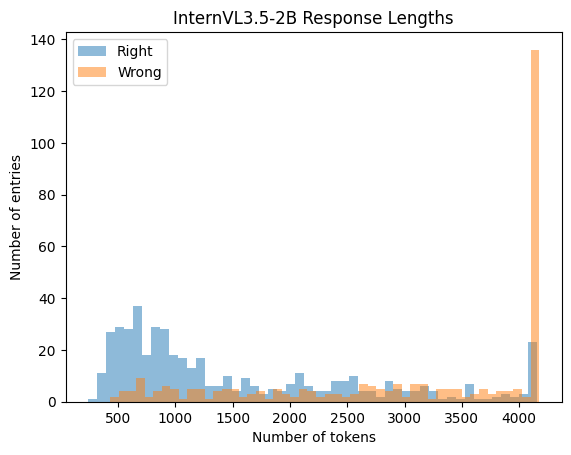

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-VL-8B-Instruct")
# draw histogram of lengths
import matplotlib.pyplot as plt

lengths_0 = []
lengths_1 = []
for score in [0, 1]:
    for entry in reorganized_data[score]:
        input_text = entry["question"] + " " + entry["response"]
        tokens = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=8192)
        if score == 0:
            lengths_0.append(tokens.input_ids.shape[1])
        else:
            lengths_1.append(tokens.input_ids.shape[1])

plt.hist(lengths_1, bins=50, alpha=0.5, label="Right")
plt.hist(lengths_0, bins=50, alpha=0.5, label="Wrong")
# Make y-axis break
plt.xlabel("Number of tokens")
plt.ylabel("Number of entries")
plt.legend()
plt.title("InternVL3.5-2B Response Lengths")
plt.show()

In [6]:
# find the most used tokens in each score group
from collections import Counter

counter_0 = Counter()
counter_1 = Counter()
for score in [0, 1]:
    for entry in reorganized_data[score]:
        input_text = entry["question"] + " " + entry["response"]
        tokens = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=8192)
        if score == 0:
            counter_0.update(tokens.input_ids[0].tolist())
        else:
            counter_1.update(tokens.input_ids[0].tolist())

for token_id, count in counter_0.most_common(10):
    print(f"Token ID: {token_id}, Count in score 0: {count}, Token: {tokenizer.decode([token_id])}")
for token_id, count in counter_1.most_common(10):
    print(f"Token ID: {token_id}, Count in score 1: {count}, Token: {tokenizer.decode([token_id])}")

Token ID: 279, Count in score 0: 478688, Token:  the
Token ID: 13, Count in score 0: 354705, Token: .
Token ID: 11, Count in score 0: 315443, Token: ,
Token ID: 374, Count in score 0: 227156, Token:  is
Token ID: 13824, Count in score 0: 78999, Token:  Wait
Token ID: 220, Count in score 0: 75915, Token:  
Token ID: 1988, Count in score 0: 73631, Token:  But
Token ID: 4226, Count in score 0: 66611, Token:  answer
Token ID: 525, Count in score 0: 60446, Token:  are
Token ID: 323, Count in score 0: 56925, Token:  and
Token ID: 279, Count in score 1: 10384, Token:  the
Token ID: 13, Count in score 1: 8668, Token: .
Token ID: 11, Count in score 1: 5451, Token: ,
Token ID: 374, Count in score 1: 4653, Token:  is
Token ID: 576, Count in score 1: 3348, Token:  The
Token ID: 389, Count in score 1: 2059, Token:  on
Token ID: 264, Count in score 1: 2021, Token:  a
Token ID: 315, Count in score 1: 1832, Token:  of
Token ID: 304, Count in score 1: 1609, Token:  in
Token ID: 220, Count in score 1: 1